GAN with feature-matching generator loss function.

In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
include("./plots.jl")

PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]
M, N = size(X)

(2, 103)

In [3]:
# GAN settings
zdim = 1 # code dimension
xdim = M # dimension of data
hiddendim = 32  

# setup the GAN model object
gsize = [zdim; hiddendim; hiddendim; xdim] # generator layout
dsize = [xdim; hiddendim*2; hiddendim*2; 1] # discriminator layout
lambda = 0.5 # anomaly score parameter in [0, 1]
# 1 - ignores the discriminator score
# 0- ignores the reconstruction error score
threshold = 0 # classification threshold, is recomputed (getthreshold or when using fit!)
contamination = size(Y[Y.==1],1)/size(Y, 1) # contamination ratio
batchsize = 50 # batchsize
iterations = 10000 # no of iterations
cbit = 2500 # when should output be printed
verbfit = true # if output should be produced
pz = randn # code distribution (rand should also work)
activation = Flux.leakyrelu # should work better than relu
layer = Flux.Dense
rdelta = 1e-5 # stop training after this reconstruction error is achieved
# this parameter is basically useless in the case of GANs
alpha = 1e-1 # weight of the classical generator loss in the total loss
# used to train generator
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
eta = 0.001
model = fmGANmodel(gsize, dsize; lambda=lambda, threshold=threshold, 
    contamination=contamination, batchsize=batchsize, iterations=iterations, 
    cbit=cbit, verbfit=verbfit, 
    pz = pz, activation = activation, rdelta = rdelta, alpha = alpha,
    Beta = Beta, tracked = tracked, layer = layer, eta = eta)

AnomalyDetection.fmGANmodel(AnomalyDetection.fmGAN(Chain(Dense(1, 32, NNlib.leakyrelu), Dense(32, 32, NNlib.leakyrelu), Dense(32, 2)), Chain(Dense(1, 32, NNlib.leakyrelu), Dense(32, 32, NNlib.leakyrelu), Dense(32, 2)), Chain(Dense(2, 64, NNlib.leakyrelu), Dense(64, 64, NNlib.leakyrelu), Dense(64, 1, NNlib.σ)), Chain(Dense(2, 64, NNlib.leakyrelu), Dense(64, 64, NNlib.leakyrelu), Dense(64, 1, NNlib.σ)), Chain(Dense(2, 64, NNlib.leakyrelu), Dense(64, 64, NNlib.leakyrelu)), randn), 0.5, 0, 0.1262135922330097, 50, 10000, 2500, true, 1.0e-5, 0.1, 1.0, MVHistory{ValueHistories.History}, 0.001)

In [4]:
# fit the model
Z = AnomalyDetection.getcode(model, size(nX, 2))
AnomalyDetection.evalloss(model, nX, Z)
AnomalyDetection.fit!(model, nX)
AnomalyDetection.evalloss(model, nX, Z)

discriminator loss: 0.66637266
feature-matching loss: 0.005706745
reconstruction error: 0.646937

discriminator loss: 0.6949247
feature-matching loss: 0.014314735
reconstruction error: 0.2083236

discriminator loss: 0.6804708
feature-matching loss: 0.0029035679
reconstruction error: 0.13486876

discriminator loss: 0.70087314
feature-matching loss: 0.004060077
reconstruction error: 0.15410599

discriminator loss: 

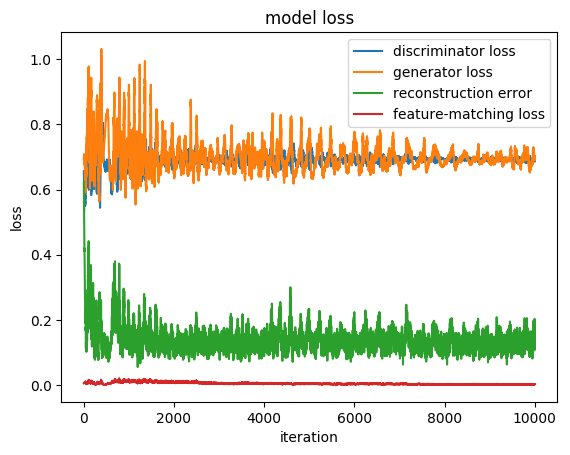

0.68989265
feature-matching loss: 0.0025502366
reconstruction error: 0.14689289

discriminator loss: 0.6893401
feature-matching loss: 0.0030644513
reconstruction error: 0.17297421



In [5]:
# plot model loss
plot(model)
show()

In [6]:
# generate new data
xgen = AnomalyDetection.generate(model, N)

2×103 Array{Float32,2}:
 -0.127904  0.803919  1.1603   -0.0275782  …  0.703703  -0.198734  0.00879936
  0.941515  0.883049  1.28022   0.943286      0.770916   0.928837  0.946161  

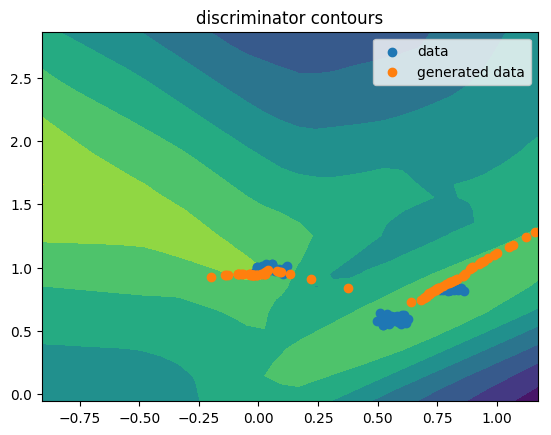

In [7]:
# plot them
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)


x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.discriminate(model, AnomalyDetection.Float.([x[j], y[i]]))[1]
    end
end

figure()
contourf(x, y, zz)
scatter(nX[1,:], nX[2,:], label = "data")
scatter(xgen[1,:], xgen[2,:], label = "generated data")
title("discriminator contours")
xlim(xl)
ylim(yl)
legend()
show()

Classification is based on anomaly score computed as a weighted average of reconstruction error and discriminator score
\begin{equation}
A(x) = (1-\lambda)D(x)+\lambda||x-G(z)||_{2, z \sim p(z)}
\end{equation}

In [8]:
# predict labels
AnomalyDetection.setthreshold!(model, X)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 1
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 1
 ⋮
 1
 1
 1
 0
 1
 0
 1
 0
 1
 1
 0
 1

In [9]:
# get all the labels
model.lambda = 0.1
AnomalyDetection.setthreshold!(model, X)
tryhat, tstyhat, _, _ = AnomalyDetection.rocstats(dataset, dataset, model);

In [10]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 10
  tn = 83
  fp = 7
  fn = 3
precision: 0.5882352941176471
f1score: 0.6666666666666666
recall: 0.7692307692307693
false positive rate: 0.07777777777777778
equal error rate: 0.15427350427350428

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 10
  tn = 85
  fp = 5
  fn = 3
precision: 0.6666666666666666
f1score: 0.7142857142857143
recall: 0.7692307692307693
false positive rate: 0.05555555555555555
equal error rate: 0.14316239316239315


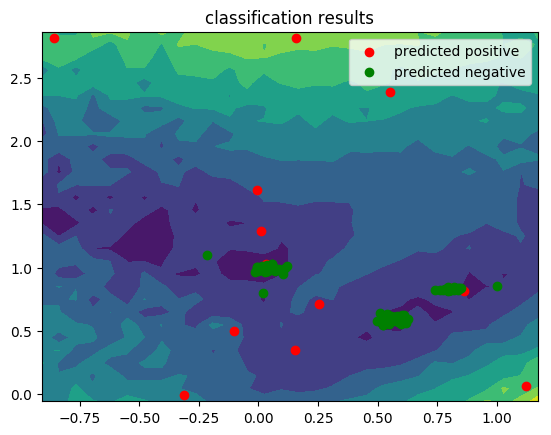

In [11]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

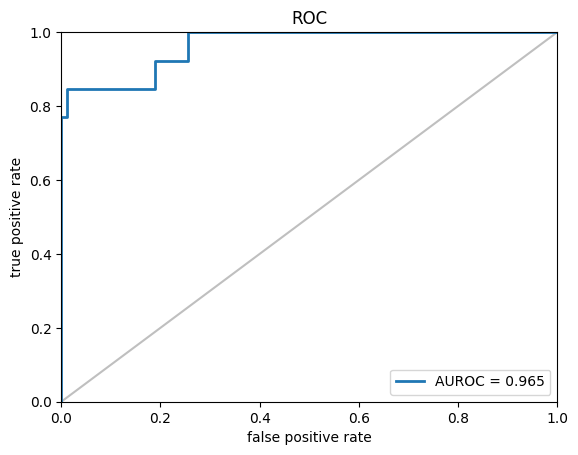

In [12]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()

In [13]:
# plot EER for different settings of lambda
using MLBase: roc, correctrate, precision, recall, f1score, false_positive_rate, false_negative_rate
n = 21
lvec = linspace(0,1,n)
eervec = zeros(n)
for i in 1:n
    model.lambda = lvec[i]
    AnomalyDetection.setthreshold!(model, X)
    tryhat, tsthat, trroc, tstroc = AnomalyDetection.rocstats(dataset.data, dataset.labels,
        dataset.data, dataset.labels, model, verb = false)
    eervec[i] = (false_positive_rate(tstroc) + false_negative_rate(tstroc))/2
end

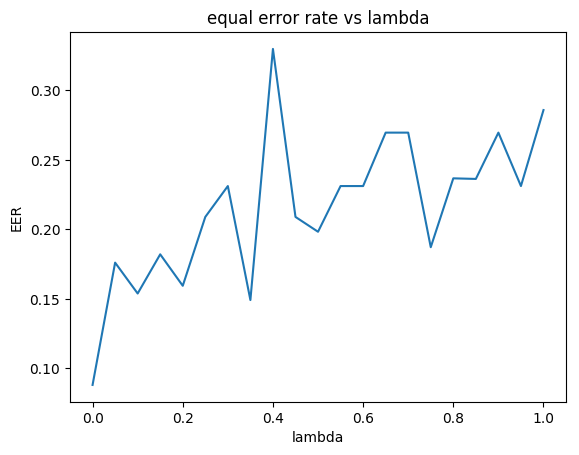

In [14]:
f = figure()
plot(lvec, eervec)
title("equal error rate vs lambda")
xlabel("lambda")
ylabel("EER")
show()